<a href="https://colab.research.google.com/github/oladimeji360/https-github.com-AdriaDelhom-CGM/blob/main/Retail_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Retail data/Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [ ]:
# 4-year furniture sales data

In [5]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [6]:
# Data Preprorocessing
# Removing columns not need, missing values, aggregate sales by date
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

,0
Order Date,0
Sales,0


In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
# Indexing Time series data
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [9]:
# Use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp
y = furniture['Sales'].resample('MS').mean()

In [11]:
# 2017 furniture sales data
y['2017':]

,Sales
Order Date,
2017-01-01,397.602133
2017-02-01,528.179800
2017-03-01,544.672240
2017-04-01,453.297905
2017-05-01,678.302328
2017-06-01,826.460291
2017-07-01,562.524857
2017-08-01,857.881889
2017-09-01,1209.508583


In [ ]:
# Visualizing Furniture Sales Time Series Data

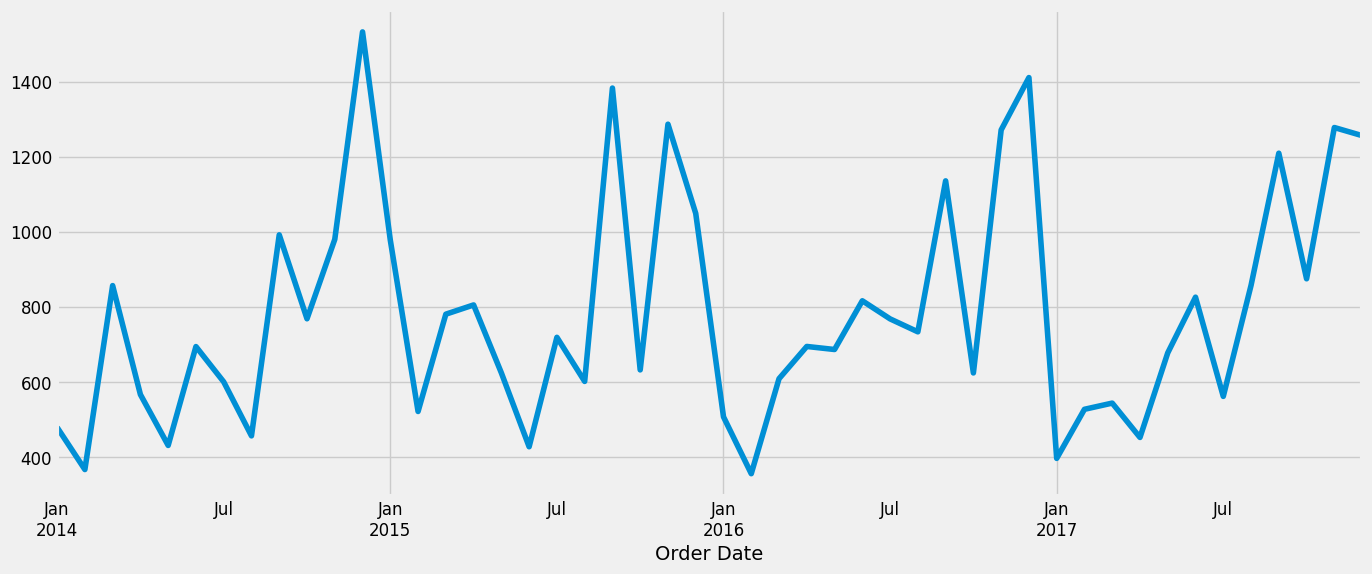

In [12]:
y.plot(figsize=(15, 6))
plt.show()

In [ ]:
# Observation
# The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year

In [ ]:
# Visualization using time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

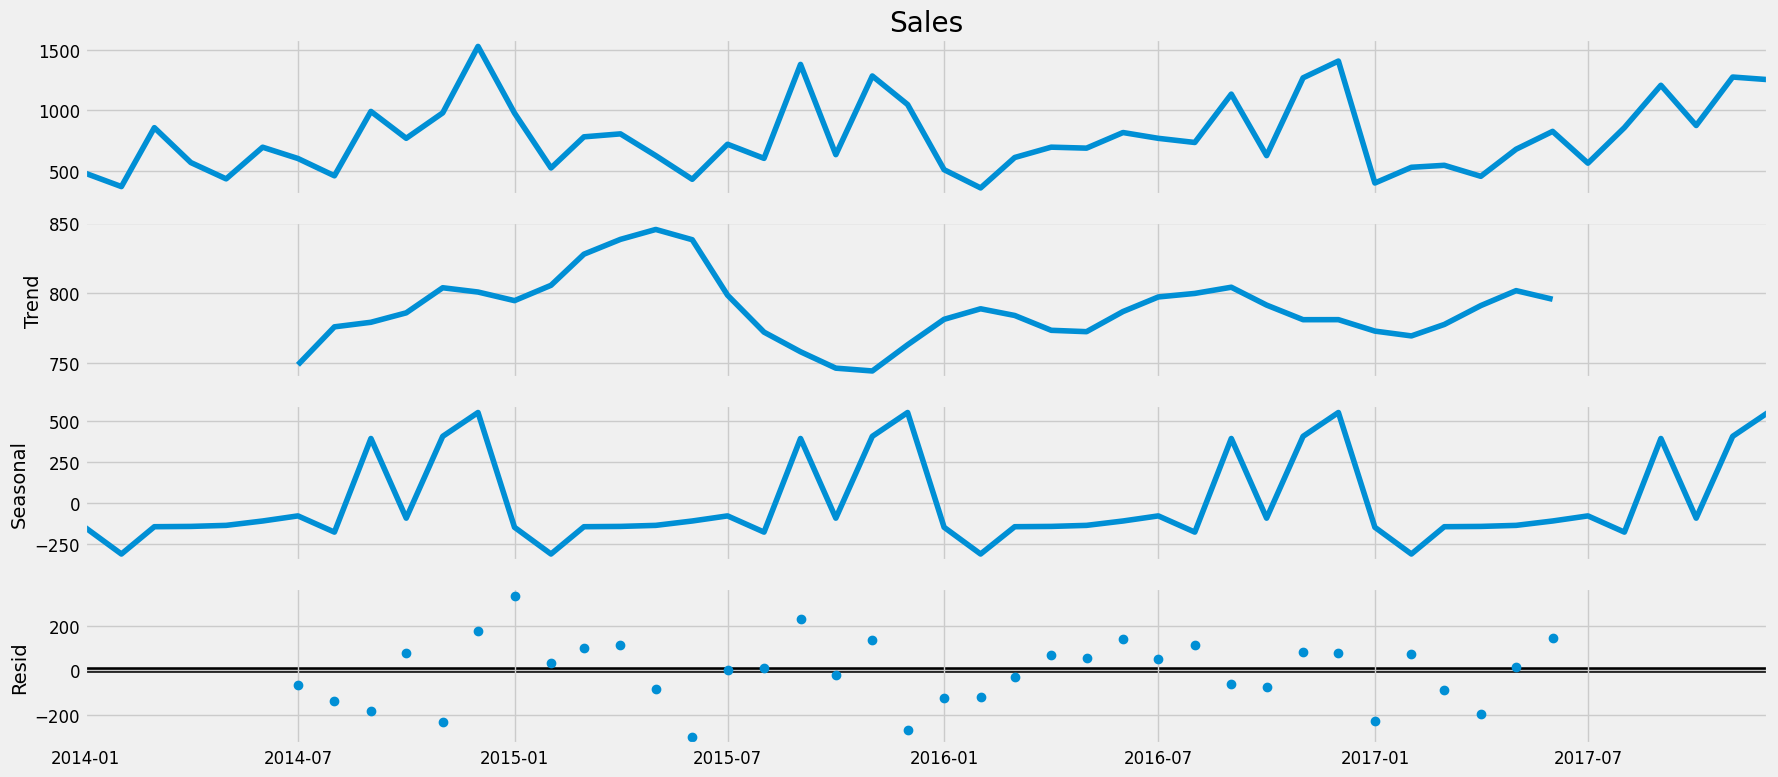

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# Observation: The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality

In [ ]:
# Time series forecasting with ARIMA
# ARIMA combines autoregressive models, moving averages, and differencing to model and predict future values of a time series

In [ ]:
# ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [25]:
# Parameter selection for furniture’s sales ARIMA Time Series Model. Goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
order=param,
seasonal_order=param_seasonal,
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
except Exception:
    pass
    pass
            continue

SyntaxError: expected 'except' or 'finally' block (<ipython-input-25-b49c2df90237>, line 10)

In [ ]:
# The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option

In [23]:
# Fitting the ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


In [ ]:
# Model diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# our model diagnostics suggests that the model residuals are near normally distributed

In [ ]:
# Validating forecasts- To help us understand the accuracy of our forecast
# We compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

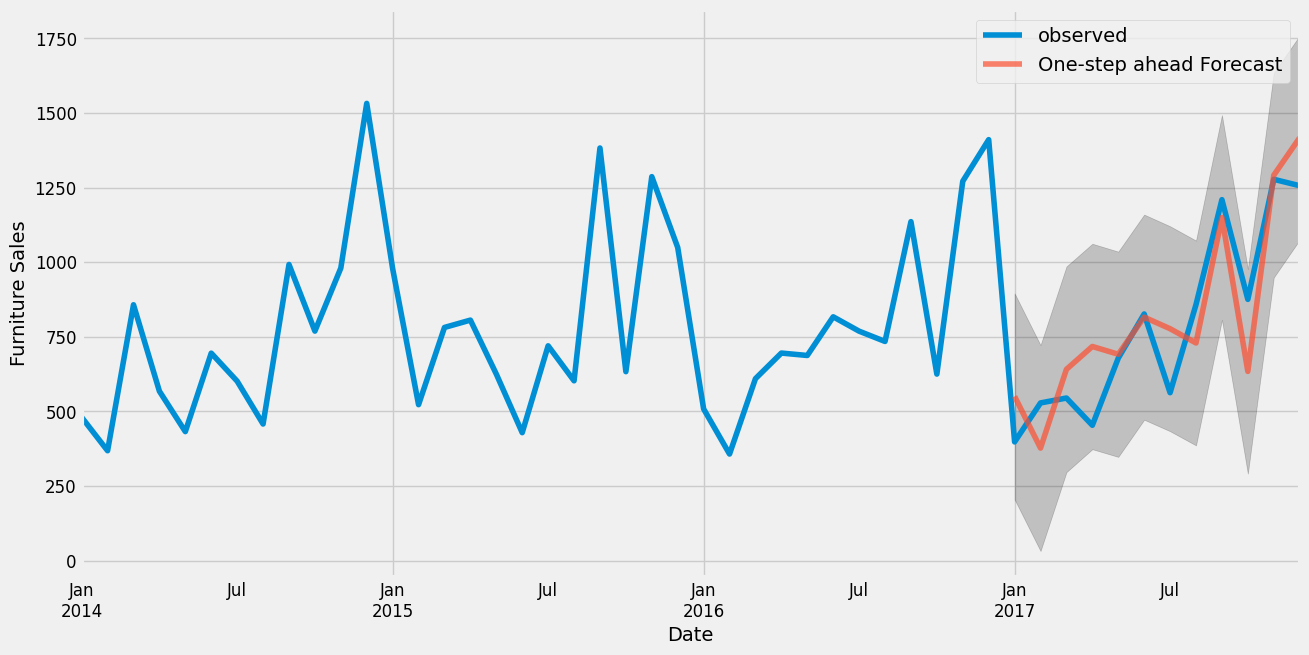

In [33]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
# Observed values compared to the rolling forecast predictions.
# Our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year

In [34]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [35]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


In [ ]:
# Mean Square Estimate (MSE):
# This measure of the quality of an estimator — always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit

In [ ]:
# Root Mean Square Error (RMSE):
# This model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

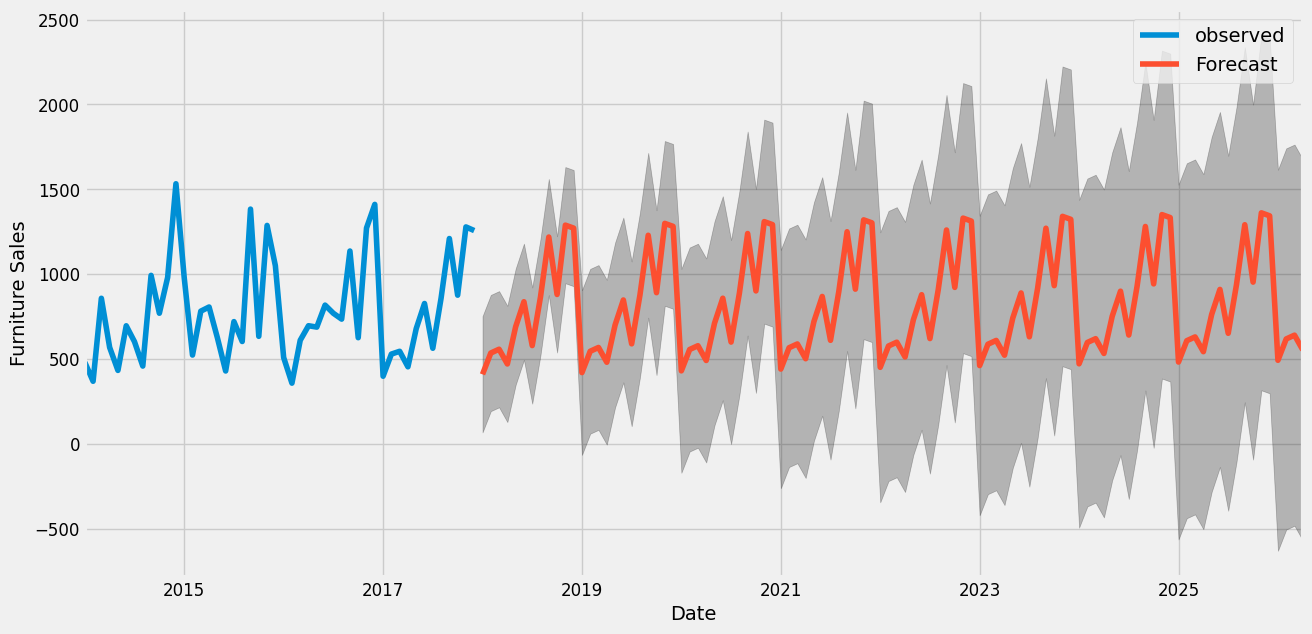

In [36]:
# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
# This model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future

In [37]:
# Time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [38]:
# Data Exploration
# To compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


from matplotlib import pyplot as plt
_df_0['furniture_sales'].plot(kind='hist', bins=20, title='furniture_sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['office_sales'].plot(kind='hist', bins=20, title='office_sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='furniture_sales', y='office_sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Order Date']
  ys = series['furniture_sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('furniture_sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Order Date']
  ys = series['office_sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('office_sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Order Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Order Date'}, axis=1)
              .sort_values('Order Date', ascending=True))
  xs = counted['Order Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Order Date']
  ys = series['furniture_sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('furniture_sales')

from matplotlib import pyplot as plt
_df_7['furniture_sales'].plot(kind='line', figsize=(8, 4), title='furniture_sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['office_sales'].plot(kind='line', figsize=(8, 4), title='office_sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['furniture_sales'].plot(kind='hist', bins=20, title='furniture_sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['office_sales'].plot(kind='hist', bins=20, title='office_sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12.plot(kind='scatter', x='index', y='furniture_sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13.plot(kind='scatter', x='furniture_sales', y='office_sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Order Date']
  ys = series['furniture_sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('furniture_sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Order Date']
  ys = series['office_sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('office_sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Order Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Order Date'}, axis=1)
              .sort_values('Order Date', ascending=True))
  xs = counted['Order Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_16.sort_values('Order Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Order Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['furniture_sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_17.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('furniture_sales')

from matplotlib import pyplot as plt
_df_18['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['furniture_sales'].plot(kind='line', figsize=(8, 4), title='furniture_sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['office_sales'].plot(kind='line', figsize=(8, 4), title='office_sales')
plt.gca().spines[['top', 'right']].set_visible(False)

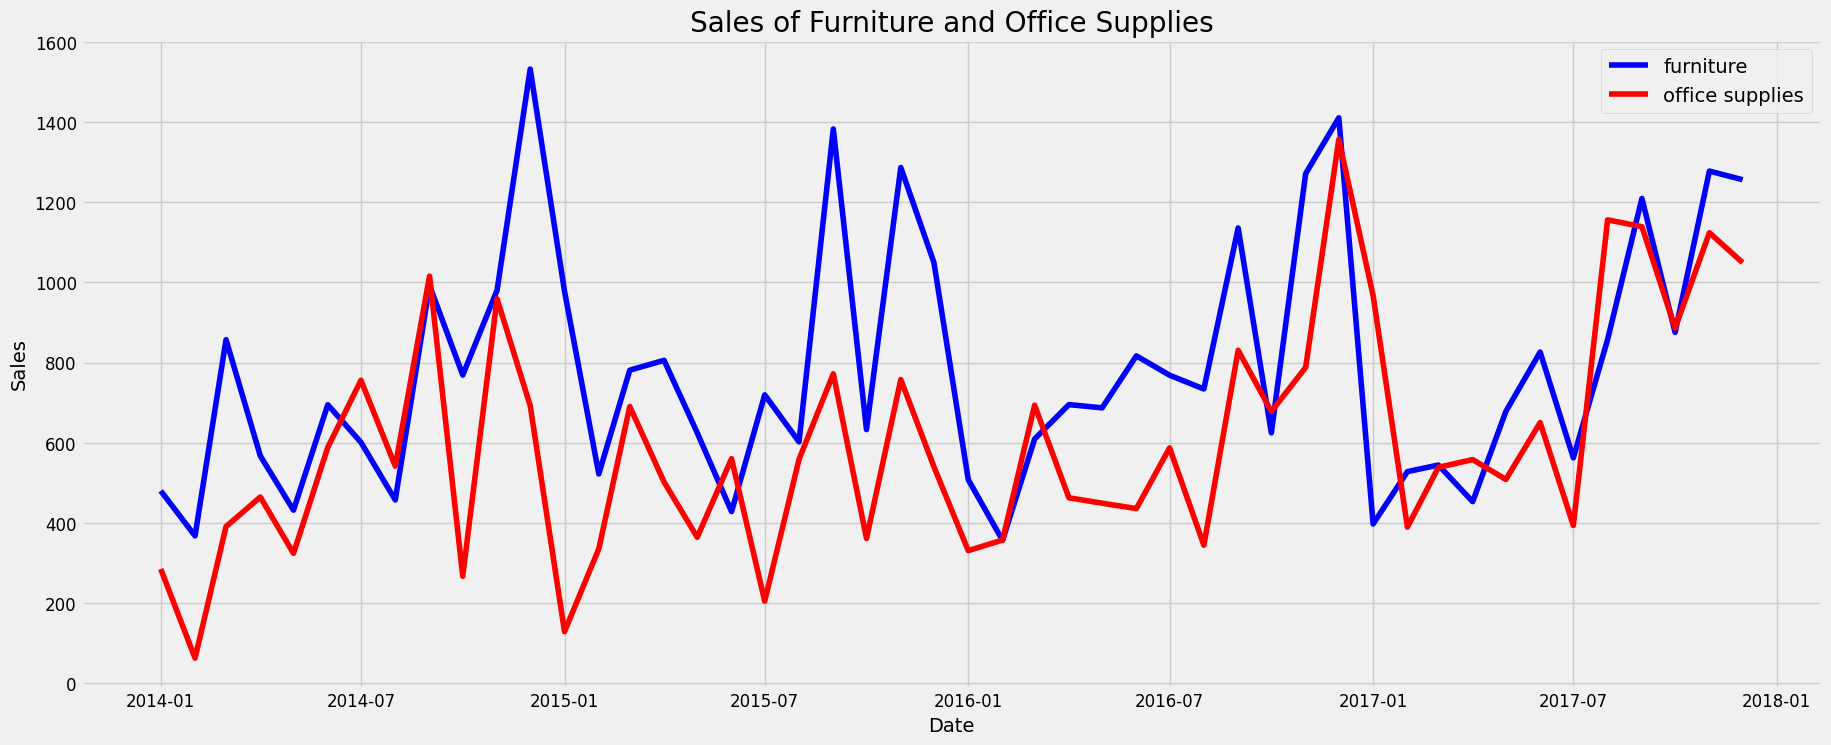

In [39]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [ ]:
# Observations: Sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s

In [ ]:
# first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9leyx2oh/vmtcbwp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9leyx2oh/gl57hc39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1681', 'data', 'file=/tmp/tmp9leyx2oh/vmtcbwp4.json', 'init=/tmp/tmp9leyx2oh/gl57hc39.json', 'output', 'file=/tmp/tmp9leyx2oh/prophet_modelclm9l__0/prophet_model-20240802231917.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

<Figure size 1800x600 with 0 Axes>

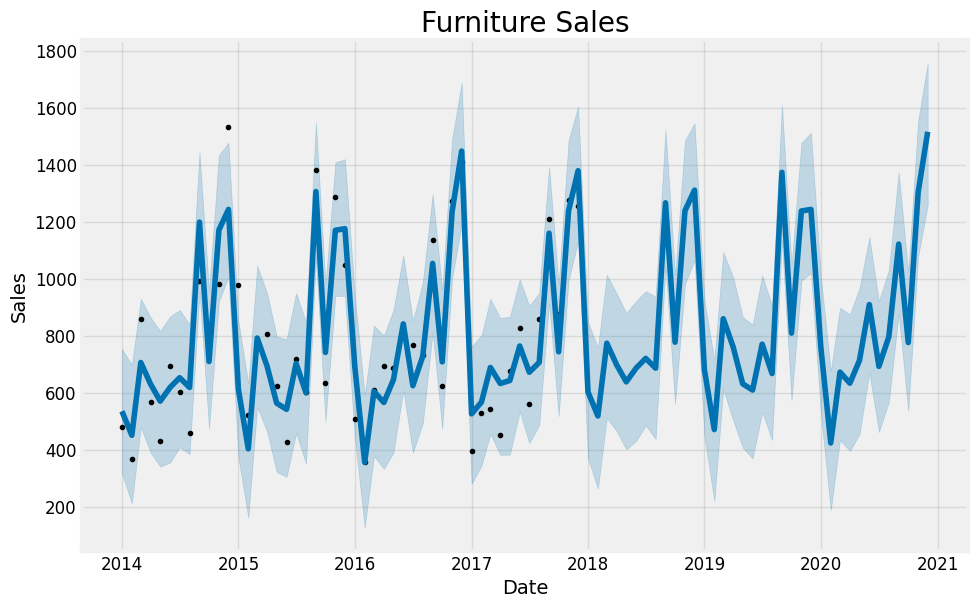

In [51]:
# Time Series Modeling with Prophet
# Forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily

# Install necessary system packages
!apt-get install -y build-essential python3-dev

# Install 'prophet' from PyPI
!pip install prophet


from prophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1800x600 with 0 Axes>

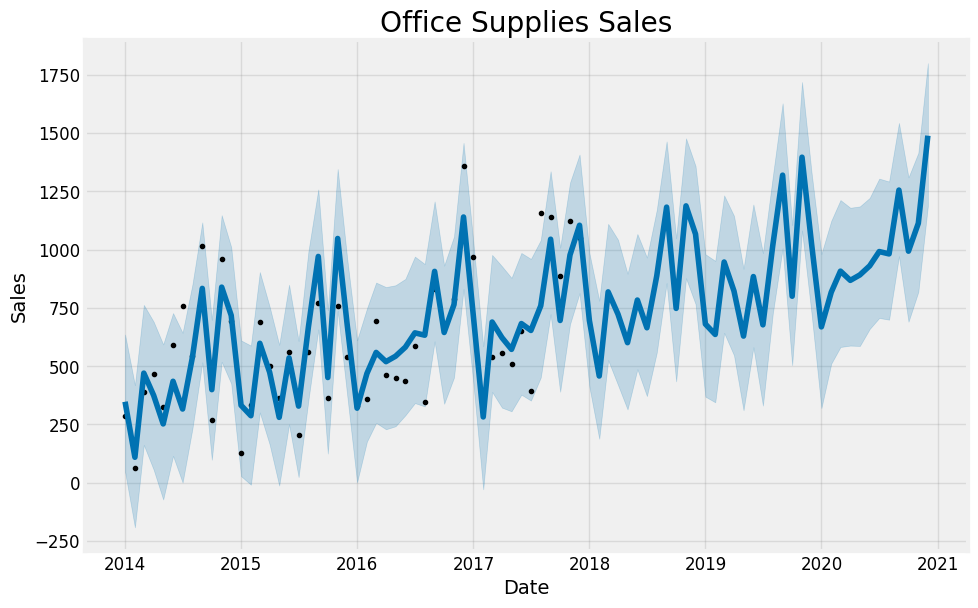

In [52]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [ ]:
# To compare Forecasts
We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts

In [53]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,316.073969,753.801854,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,212.431833,698.580689,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,479.701047,930.293156,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,390.123620,863.688268,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,341.195963,816.890616,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


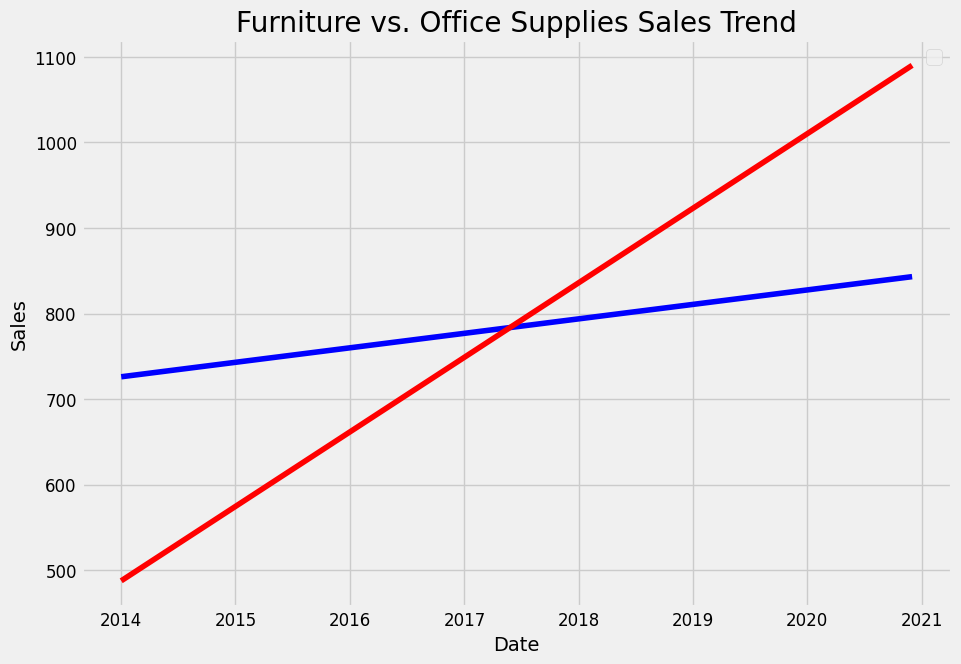

In [57]:
# Trend and Forecast Visualization
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

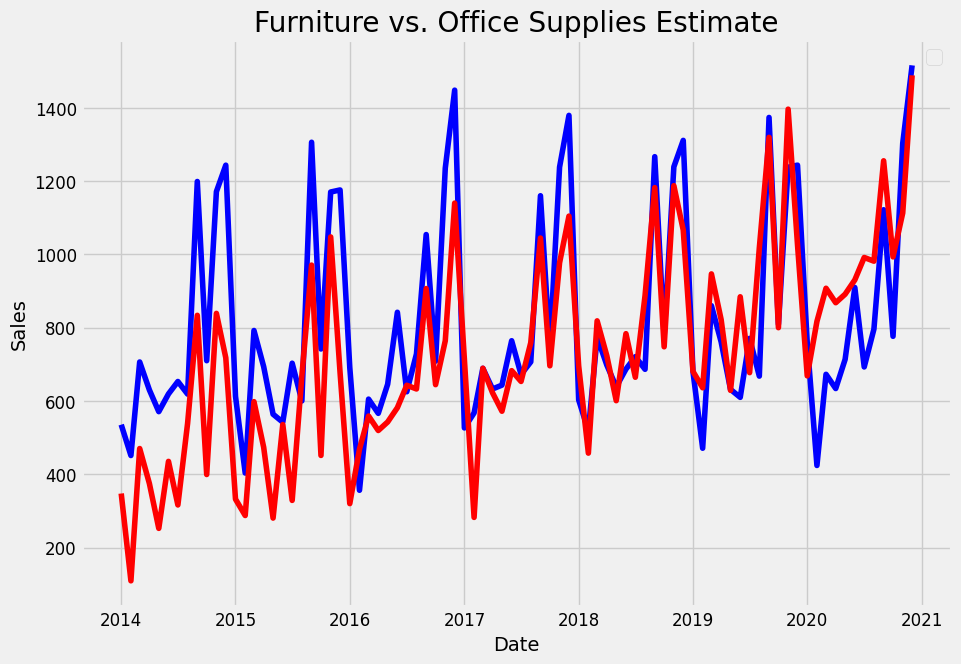

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

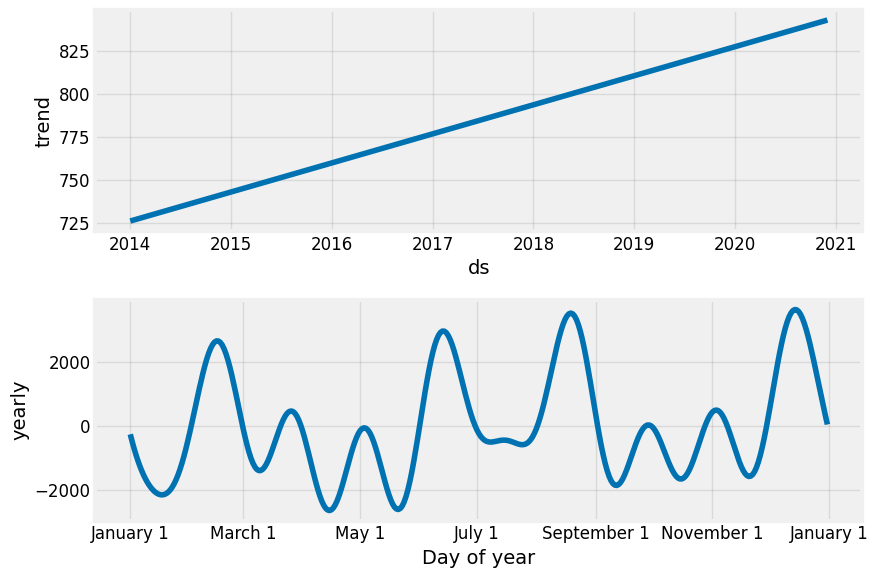

In [60]:
# Trends and Patterns
# Using Prophet Models to inspect different trends of these two categories in the data

furniture_model.plot_components(furniture_forecast);

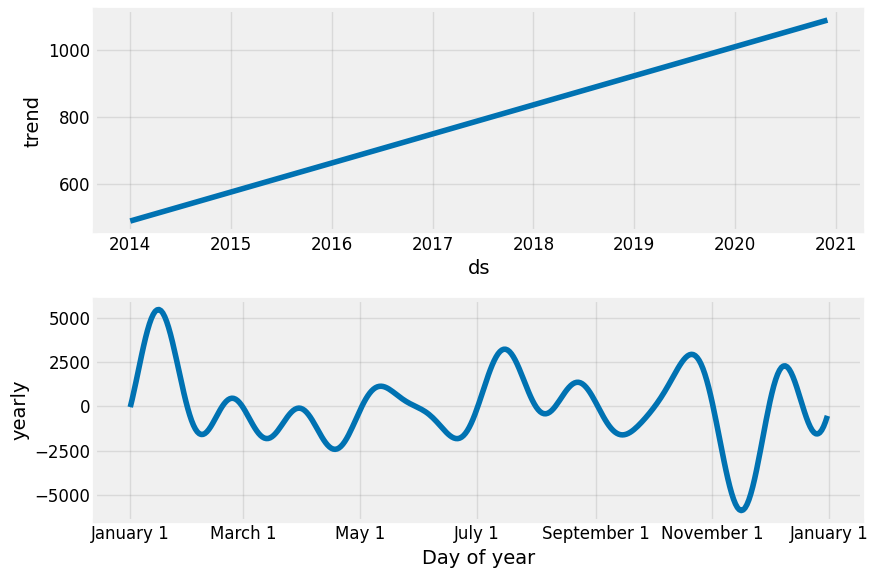

In [61]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started